In [1]:
import os, random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import InterfacePreprocessing as IntPre

from PIL import Image
from scipy.ndimage import imread
from scipy.misc import imresize
from sklearn.metrics import roc_curve, auc

%matplotlib inline

# Defining global variables

In [2]:
global raw_only, image_size, num_layer
raw_only = False
raw_image_size = 250
image_size= 88
if raw_only:
    num_layer = 1
else:
    num_layer = 6

p_matching = 0.5
num_filter_1 = 20
num_filter_2 = 40
num_filter_3 = 60

In [83]:
# ############### #
#   Helper Func   #
# ############### #

'''
# Create the same image merge with maximum 3 kind of pre-processing
def preprocessing_bare(image, size):
    
    if raw_only:
        image_temp = np.zeros((size,size,1))
        image = imresize(image, [size, size])
        image_temp[:,:,0] = image
    else:
        image_temp = np.zeros((size,size,4))
        image = imresize(image, [size, size])
        image_temp[:,:,0] = image # 180*180
        image_temp[:,:,1] = imresize(IntPre.frequency(image, step=5), [size, size])
        image_temp[:,:,2] = imresize(np.abs(IntPre.orientation(image, coherence=False)), [size, size])
        image_temp[:,:,3] = imresize(IntPre.variance(image, block=5), [size, size])
        
    return image_temp

# To load images like CASIA (no matching etc...)
def load_vrac(path):
    images = dict()

    for f in os.listdir(path):
        ID = f[:-4]
        image = imread(path+f).astype(np.int32)
        image_temp = preprocessing_bare(image, raw_image_size)
        images[ID] = image_temp
    return images

# To load images organised by pairs (of match and mismatch)
def load_pairs(path_match, path_mismatch):
    return load_vrac(path_match), load_vrac(path_mismatch)

# If images are loaded with "load_pairs"
def generate_batch_pairs(images_match, images_mismatch, num, image_size):
        
    x = np.zeros((num, image_size*image_size*num_layer))
    x_p = np.zeros((num, image_size*image_size*num_layer))
    y = np.zeros((num, 1))
    match = int(np.round(num*0.5))
    mis_match = num - match

    keys_mismatch = images_mismatch.keys()
    for i in range(mis_match):
        ID = random.choice(keys_mismatch)[:-1]
        img = images_mismatch[ID + '0']
        x1 = img[:88,:88,:]
        x2 = img[4:92,:88,:]
        x[i,:] = np.reshape(x1, (1,image_size*image_size*num_layer))
        x_p[i,:] = np.reshape(x2, (1,image_size*image_size*num_layer))
        y[i] = 0

    keys_match = images_match.keys()
    for i in range(match):
        ID = random.choice(keys_match)[:-1]
        img = images_match[ID + '0']
        x1 = img[:88,:88,:]
        x2 = img[88:176,:88,:]      
        x[mis_match+i,:] = np.reshape(x1, (1,image_size*image_size*num_layer))
        x_p[mis_match+i,:] = np.reshape(x2, (1,image_size*image_size*num_layer))
        y[mis_match+i] = 1
        
    return [x, x_p, y]
'''

def load_pairs_from_preprocessed(match_path, mismatch_path):
    images_match = dict()

    for ID in range(94):
        for pic in range(2):
            image_temp = np.zeros((image_size,image_size,num_layer))
            for layer in range(5):
                fname = str(ID+1)+'_'+str(pic)+'_'+str(layer)+'.png'
                image_temp[:,:,layer] = imresize(imread(match_path+fname).astype(np.int32),[image_size,image_size])
                
            images_match[str(ID+1)+'_'+str(pic)] = image_temp
    
    images_mismatch = dict()

    for ID in range(94):
        for pic in range(2):
            image_temp = np.zeros((image_size,image_size,num_layer))
            for layer in range(5):
                fname = str(ID+1)+'_'+str(pic)+'_'+str(layer)+'.png'
                image_temp[:,:,layer] = imresize(imread(mismatch_path+fname).astype(np.int32),[image_size,image_size])
            images_mismatch[str(ID+1)+'_'+str(pic)] = image_temp
            
    return images_match, images_mismatch

def generate_batch_pairs_from_preprocessed(images_match, images_mismatch, num, image_size):
        
    x = np.zeros((num, image_size*image_size*num_layer))
    x_p = np.zeros((num, image_size*image_size*num_layer))
    y = np.ones((num, 1))*-1
    match = int(np.round(num*0.5))
    mis_match = num - match

    keys_mismatch = images_mismatch.keys()
    for i in range(mis_match):
        ID = random.choice(keys_mismatch)[:-1]
        img = images_mismatch[ID + '0']
        img_p = images_mismatch[ID + '1']
        x[i,:] = np.reshape(img, (1,image_size*image_size*num_layer))
        x_p[i,:] = np.reshape(img_p, (1,image_size*image_size*num_layer))
        y[i] = 0

    keys_match = images_match.keys()
    for i in range(match):
        ID = random.choice(keys_match)[:-1]
        img = images_match[ID + '0']
        img_p = images_match[ID + '1']  
        x[mis_match+i,:] = np.reshape(img, (1,image_size*image_size*num_layer))
        x_p[mis_match+i,:] = np.reshape(img_p, (1,image_size*image_size*num_layer))
        y[mis_match+i] = 1
        
    return [x, x_p, y]

# ################## #
# Helper Func for tf #
# ################## #

def weight_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def assist_variable(shape):
    initial = tf.constant(0.3, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, stride=[1, 1, 1, 1]):
    return tf.nn.conv2d(x, W, strides=stride, padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def sigm(x):
    return tf.sigmoid(x)

In [84]:
# ################## #
#     Old Version    #
# ################## #

# images_match, images_mismatch = load_pairs("./PAIRS/MATCHED/CROP/", "./PAIRS/MISMATCHED/CROP/")

# for key in images_match.keys():
#     images_match[key][:,:,2] = np.abs(IntPre.orientation(images_match[key][:,:,0], coherence=False))
    
# for key in images_mismatch.keys():
#     images_mismatch[key][:,:,2] = np.abs(IntPre.orientation(images_mismatch[key][:,:,0], coherence=False))

# ################## #
#     New Version    #
# ################## #
images_match, images_mismatch = load_pairs_from_preprocessed("./PreProcessed/Match/", "./PreProcessed/MisMatch/")

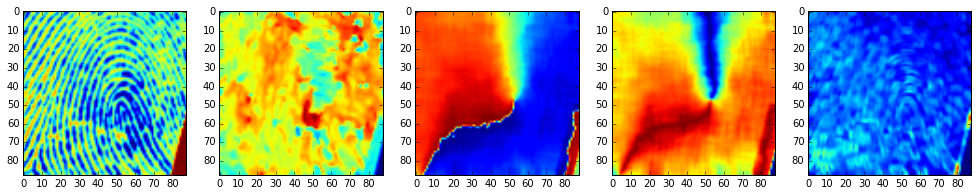

In [89]:
key = images_match.keys()[0]
plt.figure(figsize=(17,5))
ax = plt.subplot(1,5,1)
ax.imshow(images_match[key][:,:,0])
ax = plt.subplot(1,5,2)
ax.imshow(images_match[key][:,:,1])
ax = plt.subplot(1,5,3)
ax.imshow(images_match[key][:,:,2])
ax = plt.subplot(1,5,4)
ax.imshow(images_match[key][:,:,3])
ax = plt.subplot(1,5,5)
ax.imshow(images_match[key][:,:,4])

# Creating a new TF session

In [5]:
sess = tf.InteractiveSession()

# These two are input images
x = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])
x_p = tf.placeholder(tf.float32, shape=[None, image_size*image_size*num_layer])

# y_ is just a value 0(match) or 1(no match) for the two input images
y_ = tf.placeholder(tf.float32, shape=[None, 1])

# Dropout coefficient
keep_prob = tf.placeholder(tf.float32)

sess.run(tf.initialize_all_variables())

# Defining Shared Weights

In [6]:
W_conv1 = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1 = bias_variable([num_filter_1])

W_conv2 = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2 = bias_variable([num_filter_2])

W_conv3 = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3 = bias_variable([num_filter_3])

W_conv1_p = weight_variable([7, 7, num_layer, num_filter_1])
b_conv1_p = bias_variable([num_filter_1])

W_conv2_p = weight_variable([5, 5, num_filter_1, num_filter_2])
b_conv2_p = bias_variable([num_filter_2])

W_conv3_p = weight_variable([5, 5, num_filter_2, num_filter_3])
b_conv3_p = bias_variable([num_filter_3])

# Two Sides of Siamese Net

In [7]:
# ############### #
#      Side 1     #
# ############### #

# Input Image
x_image = tf.reshape(x, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Second Conv Layer - after maxpool 22*22
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Third Conv Layer - after maxpool 11*11
h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# Final Data Processing Step
z = tf.reshape(h_pool3, [-1,image_size/4*image_size/4*num_filter_3])
# z = tf.reshape(h_pool3, [-1,4*4*256])
z_norm = tf.pow(tf.reduce_sum(tf.pow(z, 2), reduction_indices=1),0.5)

# ############### #
#      Side 2     #
# ############### #

# Input Image
x_image_p = tf.reshape(x_p, [-1,image_size,image_size,num_layer])

# First Conv Layer - after maxpool 44*44
h_conv1_p = tf.nn.relu(conv2d(x_image_p, W_conv1_p) + b_conv1_p)
h_pool1_p = max_pool_2x2(h_conv1_p)

# Second Conv Layer - after maxpool 22*22
h_conv2_p = tf.nn.relu(conv2d(h_pool1_p, W_conv2_p) + b_conv2_p)
h_pool2_p = max_pool_2x2(h_conv2_p)

# Third Conv Layer - after maxpool 11*11
h_conv3_p = tf.nn.relu(conv2d(h_pool2_p, W_conv3_p) + b_conv3_p)
h_pool3_p = max_pool_2x2(h_conv3_p)

# Final Data Processing Step
z_p = tf.reshape(h_pool3_p, [-1,image_size/4*image_size/4*num_filter_3])
# z_p = tf.reshape(h_pool3_p, [-1,4*4*256])
z_p_norm = tf.pow(tf.reduce_sum(tf.pow(z_p, 2), reduction_indices=1),0.5)

# Actual Calculation

In [11]:
# fc

W_fc1 = weight_variable([image_size/4*image_size/4*num_filter_3, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, image_size/4*image_size/4*num_filter_3])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)







# distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
# cross_entropy = tf.pow(tf.reduce_sum(tf.pow(distance, 2), reduction_indices=1), 0.5)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)



sess.run(tf.initialize_all_variables())

for i in range(100):
    batch = generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size)
    if i%10 == 0:
#         train_accuracy = accuracy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
#         print("step %d, training accuracy %g"%(i, train_accuracy))
        c_e = cross_entropy.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
        print c_e
    train_step.run(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})

[ 4.95686674]
[ 4.94961452]
[ 4.93723059]
[ 4.94575405]
[ 4.96087742]
[ 4.93959904]
[ 4.92620993]
[ 4.95053911]
[ 4.93591022]
[ 4.94702148]


In [36]:
distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm)
batch = generate_batch_pairs_from_preprocessed(images_match, images_mismatch, 50, image_size)

prediction = []
results = distance.eval(feed_dict={x:batch[0], x_p:batch[1], y_: batch[2], keep_prob: 1.0})
# for i in range(50):
#     if results[0][i]<0:
#         prediction.append(1)
#     else:
#         prediction.append(0)
    
# accuracy = np.mean(np.equal(prediction, np.concatenate(batch[2])))
print results

[ 0.99450934  0.98707265  0.99012041  0.99134076  0.9905026   0.9730041
  0.99020004  0.98834056  0.99211174  0.98171425  0.99371362  0.98341864
  0.99823254  0.98707265  0.97350067  0.98498136  0.99450934  0.99245226
  0.99487162  0.98498136  0.98882139  0.9944014   0.99017096  0.99105322
  0.98912936  0.99415046  0.99849492  0.99923211  0.99979937  0.9993993
  0.99587786  0.99909037  0.98887891  0.99983054  0.98461443  0.96684915
  0.99915385  0.99849689  0.99843818  0.99794775  0.98550296  0.99972767
  0.9993993   0.99538893  0.98858649  0.98270875  0.98270875  0.99935204
  0.99889314  0.99532515]


# Below is the test on MNIST

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def generate_batch_mnist_train(n):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        
        batch = mnist.train.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            mismatched -= 1
            
    return [x, x_p, y]  

def generate_batch_mnist_test(n):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        
        batch = mnist.test.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            mismatched -= 1
            
    return [x, x_p, y]  

def generate_batch_mnist_validation(n):
    x, x_p = np.zeros((n, 784)), np.zeros((n, 784))
    y = np.zeros((n,1))
    
    matched = 0
    mismatched = np.round(n/2)
    while matched < np.round(n/2):
        
        batch = mnist.validation.next_batch(2)
        
        if np.argmax(batch[1],axis=1)[0] == np.argmax(batch[1],axis=1)[1]:
            x[matched,:] = batch[0][0,:]
            x_p[matched,:] = batch[0][1,:]
            y[matched] = 1
            matched += 1
            
        elif mismatched > 0:
            x[-mismatched,:] = batch[0][0,:]
            x_p[-mismatched,:] = batch[0][1,:]
            mismatched -= 1
            
    return [x, x_p, y]  

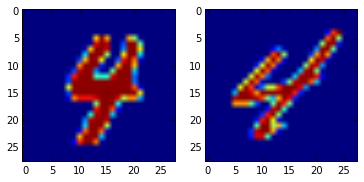

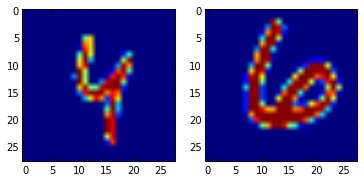

In [108]:
batch = generate_batch_mnist(2)

for i in range(2):
    plt.figure()
    ax = plt.subplot(1,2,1)
    ax.imshow(np.reshape(batch[0][i,:],(28,28)))
    ax = plt.subplot(1,2,2)
    ax.imshow(np.reshape(batch[1][i,:],(28,28)))

In [113]:
distance = tf.div(tf.reduce_sum(z*z_p, reduction_indices=1), z_norm*z_p_norm) - tf.transpose(y_)
cross_entropy = tf.pow(tf.reduce_sum(tf.pow(distance, 2), reduction_indices=1),0.5)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

rounded = tf.round(cross_entropy*-1)
correct_prediction = tf.equal(rounded,tf.transpose(y_))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess.run(tf.initialize_all_variables())

for i in range(10000):
    mnist_batch = generate_batch_mnist(50)
    if i%500 == 0:
        c_e = cross_entropy.eval(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})
        print c_e
#         print "Accuracy %g" %accuracy.eval(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})

    train_step.run(feed_dict={x:mnist_batch[0], x_p:mnist_batch[1], y_: mnist_batch[2], keep_prob: 1.0})

[ 4.98591566]
[ 4.67949152]
[ 3.93264318]
[ 3.62963438]
[ 3.58553195]
[ 3.56811047]
[ 3.46120787]
[ 3.55042887]
[ 3.47272086]
[ 3.62563396]
[ 3.53395128]


KeyboardInterrupt: 

# Digit on one side

In [40]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import tensorflow as tf
sess = tf.InteractiveSession()

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')


x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

# 1 - output 14*14*20

W_conv1 = weight_variable([7, 7, 1, 20])
b_conv1 = bias_variable([20])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2 - output 7*7*80

W_conv2 = weight_variable([5, 5, 20, 40])
b_conv2 = bias_variable([40])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 3 - output 4*4*320

W_conv3 = weight_variable([5, 5, 40, 80])
b_conv3 = bias_variable([80])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# fc

W_fc1 = weight_variable([4*4*80, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*80])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

sess.run(tf.initialize_all_variables())

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Exception AssertionError: AssertionError() in <bound method InteractiveSession.__del__ of <tensorflow.python.client.session.InteractiveSession object at 0x118106e10>> ignored


In [42]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(800):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


test accuracy 0.9603


In [23]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import tensorflow as tf

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

# 1 - output 14*14*20

W_conv1 = weight_variable([7, 7, 1, 20])
b_conv1 = bias_variable([20])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2 - output 7*7*80

W_conv2 = weight_variable([5, 5, 20, 40])
b_conv2 = bias_variable([40])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 3 - output 4*4*320

W_conv3 = weight_variable([5, 5, 40, 80])
b_conv3 = bias_variable([80])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# fc

W_fc1 = weight_variable([4*4*80, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*80])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

# Add ops to save and restore all the variables.
saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})
# saver = tf.train.Saver()

init_op = tf.initialize_all_variables()
# Later, launch the model, initialize the variables, do some work, save the
# variables to disk.
with tf.Session() as sess:
    sess.run(init_op)
    
    # Do some work with the model.
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    sess.run(tf.initialize_all_variables())
    
    for i in range(1000):
        batch = mnist.train.next_batch(50)
        if i%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    print("test accuracy %g"%accuracy.eval(feed_dict={
        x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    
    # Save the variables to disk.
    
    save_path = saver.save(sess, "one_sided.ckpt")
    print("Model saved in file: %s" % save_path)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.1
step 100, training accuracy 0.74
step 200, training accuracy 0.92
step 300, training accuracy 0.86
step 400, training accuracy 0.98
step 500, training accuracy 0.92
step 600, training accuracy 0.98
step 700, training accuracy 0.92
step 800, training accuracy 0.9
step 900, training accuracy 1
test accuracy 0.96
Model saved in file: one_sided.ckpt


Model restored.


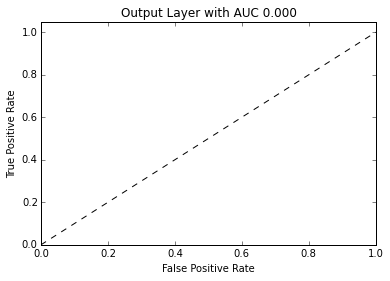

In [73]:
# Create some variables.
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

# 1 - output 14*14*20

W_conv1 = weight_variable([7, 7, 1, 20])
b_conv1 = bias_variable([20])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# 2 - output 7*7*80

W_conv2 = weight_variable([5, 5, 20, 40])
b_conv2 = bias_variable([40])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# 3 - output 4*4*320

W_conv3 = weight_variable([5, 5, 40, 80])
b_conv3 = bias_variable([80])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

# fc

W_fc1 = weight_variable([4*4*80, 1024])
b_fc1 = bias_variable([1024])

h_pool3_flat = tf.reshape(h_pool3, [-1, 4*4*80])
h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

init_op = tf.initialize_all_variables()

# Add ops to save and restore all the variables.
saver = tf.train.Saver({"W1": W_conv1, "W2": W_conv2,"W3": W_conv3,
                        "b1": b_conv1,"b2": b_conv2,"b3": b_conv3,
                        "W_fc1": W_fc1, "b_fc1": b_fc1,
                        "W_fc2": W_fc2, "b_fc2": b_fc2})

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
    
    
    # Do some work with the model.
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    sess.run(init_op)
    sess.run(tf.initialize_all_variables())
    
    
    # Restore variables from disk.
    saver.restore(sess, "one_sided.ckpt")
    print("Model restored.")
    
    
    
    batch = generate_batch_mnist_train(50)
    left = batch[0]
    right = batch[1]
    label = batch[2]
    left_output = y_conv.eval(feed_dict={x:left, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
    right_output = y_conv.eval(feed_dict={x:right, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
    
    # plt.plot(np.sum(left_output*right_output, axis=1),'.')
#     fpr, tpr, thresholds = roc_curve(label, -np.linalg.norm(left_output-right_output, axis=1))
    
#     fpr, tpr, thresholds = roc_curve(label, 
#                                      np.sum(left_output*right_output/(np.linalg.norm(left_output)*np.linalg.norm(right_output)), 
#                                             axis=1))

    cd = np.zeros(50)
    diff = left_output-right_output
    for i in range(50):
        cd[i] = np.linalg.norm(diff[i])*label[i]+(1-label[i])*np.square(np.max([0,5-np.linalg.norm(diff[i])]))
    
    fpr, tpr, thresholds = roc_curve(label, -cd)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('Output Layer with AUC %.3f' %auc(fpr, tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
#     batch = generate_batch_mnist(50)
#     left = batch[0]
#     right = batch[1]
#     label = batch[2]
#     left_output = h_fc1.eval(feed_dict={x:left, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
#     right_output = h_fc1.eval(feed_dict={x:right, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})

# #     fpr, tpr, thresholds = roc_curve(label, 
# #                                      np.sum(left_output*right_output/(np.linalg.norm(left_output)*np.linalg.norm(right_output)), 
# #                                             axis=1))

# #     fpr, tpr, thresholds = roc_curve(label,-np.linalg.norm(left_output-right_output, axis=1))
    
#     cd = np.zeros(50)
#     diff = left_output-right_output
#     for i in range(50):
#         cd[i] = np.linalg.norm(diff[i])*label[i]+(1-label[i])*np.square(np.max([0,1-np.linalg.norm(diff[i])]))
    
#     fpr, tpr, thresholds = roc_curve(label, cd)
    

#     plt.figure()
#     plt.plot(fpr, tpr)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.title('Fully Connected with AUC %.3f' %auc(fpr, tpr))
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
    
#     batch = generate_batch_mnist(50)
#     left = batch[0]
#     right = batch[1]
#     label = batch[2]
#     left_output = h_pool3_flat.eval(feed_dict={x:left, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})
#     right_output = h_pool3_flat.eval(feed_dict={x:right, y_: mnist.train.next_batch(50)[1], keep_prob: 1.0})

# #     fpr, tpr, thresholds = roc_curve(label, 
# #                                      np.sum(left_output*right_output/(np.linalg.norm(left_output)*np.linalg.norm(right_output)), 
# #                                             axis=1))
    
    
#     cd = np.zeros(50)
#     diff = left_output-right_output
#     for i in range(50):
#         cd[i] = np.linalg.norm(diff[i])*label[i]+(1-label[i])*np.square(np.max([0,5-np.linalg.norm(diff[i])]))
    
#     fpr, tpr, thresholds = roc_curve(label, cd)

#     plt.figure()
#     plt.plot(fpr, tpr)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.title('Convolutional Output with AUC %.3f' %auc(fpr, tpr))
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')

In [69]:
left_output.shape

(50, 1024)

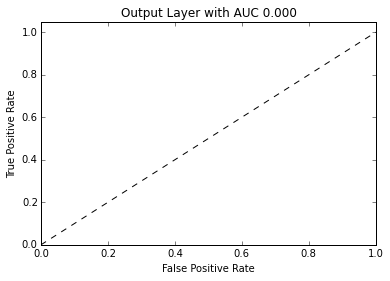

In [81]:
cd = np.zeros(50)
diff = left_output-right_output
for i in range(50):
    cd[i] = np.linalg.norm(diff[i])*label[i]+(1-label[i])*np.square(np.max([0,5-np.linalg.norm(diff[i])]))

fpr, tpr, thresholds = roc_curve(label, cd-0.5)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Output Layer with AUC %.3f' %auc(fpr, tpr))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [82]:
cd-.5

array([ -0.47594535,  -0.49731599,  -0.49669972,  -0.49999588,
        -0.49403144,  -0.49294716,  -0.49610679,  -0.31834733,
        -0.49979787,  -0.49898938,  -0.48883578,  -0.49699002,
        -0.49994729,  -0.49998237,  -0.49066002,   0.24407178,
        -0.49230091,  -0.47856034,  -0.47367681,  -0.49573217,
        -0.16089156,  -0.49976821,  -0.31662363,  -0.28377593,
        -0.48689591,  12.46736635,  12.3712398 ,  13.39608587,
        12.36191889,  12.37812297,  12.39298545,  13.29567497,
        13.68271045,  12.78270796,  12.38269993,  13.28074957,
        12.38075233,  12.36642028,  13.36386378,  12.46525097,
        12.52658366,  16.4877239 ,  12.3697823 ,  12.68324108,
        13.76622481,  13.34058478,  14.78443262,  12.44736468,
        12.36871489,  14.31995034])